# Amplitude Matching for Multizone Sound Field Control

A multizone sound field control method to synthesize a desired amplitude (or magnitude) distributions over a target region with multiple loudspeakers
- Paper: https://doi.org/10.1109/TASLP.2022.3231715
- Codes: https://github.com/sh01k/AmplitudeMatching

by Takumi Abe, [Shoichi Koyama](https://www.sh01.org/), [Natsuki Ueno](https://natsuenono.github.io/), and [Hiroshi Saruwatari](https://researchmap.jp/read0102891/)

## Codes for reproducing results in Sect. IV-C
Download [MeshRIR dataset](https://www.sh01.org/MeshRIR/) and place irutilities.py and S32-M441_npy in the same directory. 
### General settings

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as distfuncs
from scipy import signal
from pathlib import Path

import sf_func as sf
import irutilities as irutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
"""Load IR data"""
sessionName = "S32-M441_npy"
sessionPath = Path('.').joinpath(sessionName)
posAll, posSPK, irAll_raw = irutil.loadIR(sessionPath)

numAll = posAll.shape[0]
numSPK = posSPK.shape[0]

posAllX = np.unique(posAll[:,0].round(4))
posAllY = np.unique(posAll[:,1].round(4))
numAllXY = (posAllX.shape[0], posAllY.shape[0])

# Sampling rate (original)
samplerate_raw = 48000

samplerate (Hz):  16000
ir length: 8192


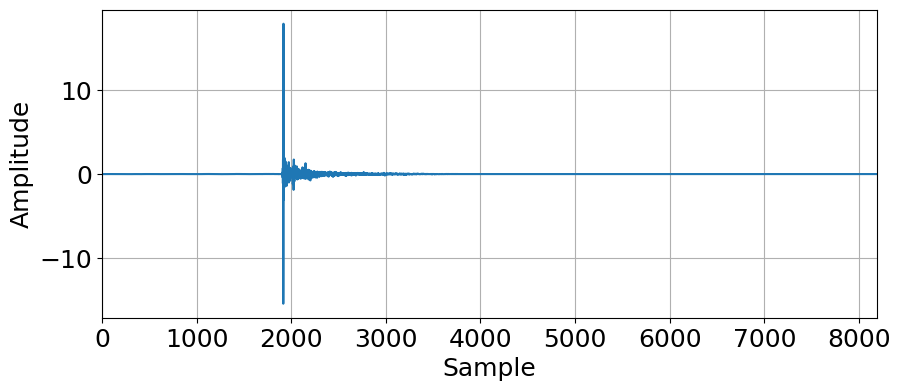

In [14]:
# Downsampling
downSampling = 3
irAll = signal.resample_poly(irAll_raw, up=1, down=downSampling, axis=-1)
samplerate = samplerate_raw // downSampling
print('samplerate (Hz): ', samplerate)

posAllXY, _, idxAllXY = irutil.sortIR(posAll[:,0:2], irAll, numAllXY, posAllX, posAllY)

# Truncation of IRs
irLen = 8192
irAll = np.transpose(irAll, (2,1,0))
irAll = irAll[0:irLen,:,:]
print('ir length:', irLen)

# Tukey window
lenWin = 4200
winTukey = np.zeros(irLen)
winTukey[0:lenWin] = signal.windows.tukey(lenWin*2, 0.3)[lenWin::]
irSim = irAll*winTukey[:,None,None]

# Plot IR
plt.rcParams["font.size"] = 18 # Font size for plots

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(irSim[:,0,0])
ax.set_xlim(0,irLen)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

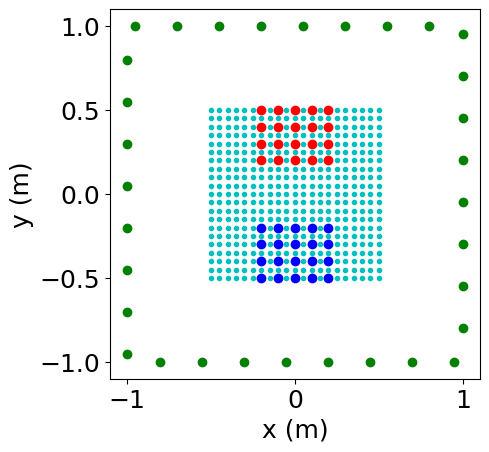

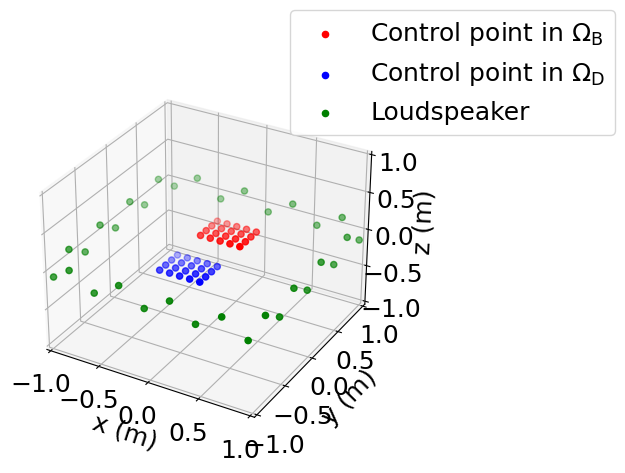

In [15]:
"""Target region and simulation points"""
dimsSim = [1.0, 1.0]
idxSimXY = idxAllXY
posSim = posAll
numSim = posSim.shape[0]
posSimXY = posAllXY
posSimX = np.unique(posSim[:,0].round(4))
posSimY = np.unique(posSim[:,1].round(4))
numSimX = posSimX.shape[0]
numSimY = posSimY.shape[0]

dimsCP = [0.4, 0.3] # Dimension of target regions
centCP_U = np.array([0.0, 0.4]) # Center position of upper target region
centCP_L = np.array([0.0, -0.4]) # Center position of lower target region

# Control points in upper target region
xGrid_U = np.arange(centCP_U[0]-dimsCP[0]/2, centCP_U[0]+dimsCP[0]/2+0.05, 0.1)
yGrid_U = np.arange(centCP_U[1]-dimsCP[1]/2-0.05, centCP_U[1]+dimsCP[1]/2, 0.1)

xIdx_U = []
for ii in np.arange(xGrid_U.shape[0]):
    xIdx_U.append(np.where( np.isclose(posSim[:,0], xGrid_U[ii]) ))
yIdx_U = []
for ii in np.arange(yGrid_U.shape[0]):
    yIdx_U.append(np.where( np.isclose(posSim[:,1], yGrid_U[ii]) ))
idxCP_U = np.intersect1d(xIdx_U, yIdx_U)
numCP_U = idxCP_U.shape[0]
posCP_U = posSim[idxCP_U,:]
irCP_U = irSim[:,idxCP_U,:]

# Control points in lower target region
xGrid_L = np.arange(centCP_L[0]-dimsCP[0]/2, centCP_L[0]+dimsCP[0]/2+0.05, 0.1)
yGrid_L = np.arange(centCP_L[1]-dimsCP[1]/2+0.05, centCP_L[1]+dimsCP[1]/2+0.1, 0.1)

xIdx_L = []
for ii in np.arange(xGrid_L.shape[0]):
    xIdx_L.append(np.where( np.isclose(posSim[:,0], xGrid_L[ii]) ))
yIdx_L = []
for ii in np.arange(yGrid_L.shape[0]):
    yIdx_L.append(np.where( np.isclose(posSim[:,1], yGrid_L[ii]) ))
idxCP_L = np.intersect1d(xIdx_L, yIdx_L)
numCP_L = idxCP_L.shape[0]
posCP_L = posSim[idxCP_L,:]
irCP_L = irSim[:,idxCP_L,:]

# Control points in total
idxCP = np.concatenate([idxCP_U, idxCP_L]) # Indexes of total control points
posCP = posSim[idxCP,:] # Position of total control points
numCP = posCP.shape[0] # Number of control points
irCP = irSim[:,idxCP,:]

# Desired amplitude distribution
des_U = np.ones(numCP_U)
des_L = np.zeros(numCP_L)
des = np.concatenate([des_U, des_L])

# Draw geometry
fig, ax = plt.subplots()
ax.scatter(posSim[:,0], posSim[:,1], marker='.', color='c')
#ax.scatter(posEval[:,0], posEval[:,1], marker='.', color='m')
ax.scatter(posCP_U[:,0], posCP_U[:,1], marker='o', color='r')
ax.scatter(posCP_L[:,0], posCP_L[:,1], marker='o', color='b')
ax.scatter(posSPK[:,0], posSPK[:,1], marker='o', color='g')
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(posCP_U[:,0], posCP_U[:,1], posCP_U[:,2], s=20, c='r', depthshade=True, label="Control point in " r'$\Omega_{\mathrm{B}}$')
ax.scatter3D(posCP_L[:,0], posCP_L[:,1], posCP_L[:,2], s=20, c='b', depthshade=True, label="Control point in " r'$\Omega_{\mathrm{D}}$')
ax.scatter3D(posSPK[:,0], posSPK[:,1], posSPK[:,2], s=20, c='g', depthshade=True,label="Loudspeaker")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")
plt.legend(bbox_to_anchor=(0.7,1.2),loc='upper left')
plt.show()

### Figure 17: Filters in time domain

In [16]:
"""Parameters"""
c = 340 #341.9  # Sound speed (m/s)
numFreq = 4096
fftlen = 8192
freqVec = np.linspace(0, 8000, numFreq+1)[1:]
k = 2.0 * np.pi * freqVec / c # Wave number
filterLen = 4096

idxPlot = 20

# Transfer Function Matrices
G = np.fft.fft(irCP, n=fftlen, axis=0)[1:int(fftlen/2)+1,:,:]
GU = np.fft.fft(irCP_U, n=fftlen, axis=0)[1:int(fftlen/2)+1,:,:]
GL = np.fft.fft(irCP_L, n=fftlen, axis=0)[1:int(fftlen/2)+1,:,:]

# Regularization parameter
U, s, V = np.linalg.svd(np.transpose(G.conj(),(0,2,1)) @ G)
reg = np.max(s, axis=1) * 1e-3

Text(0, 0.5, 'Amplitude')

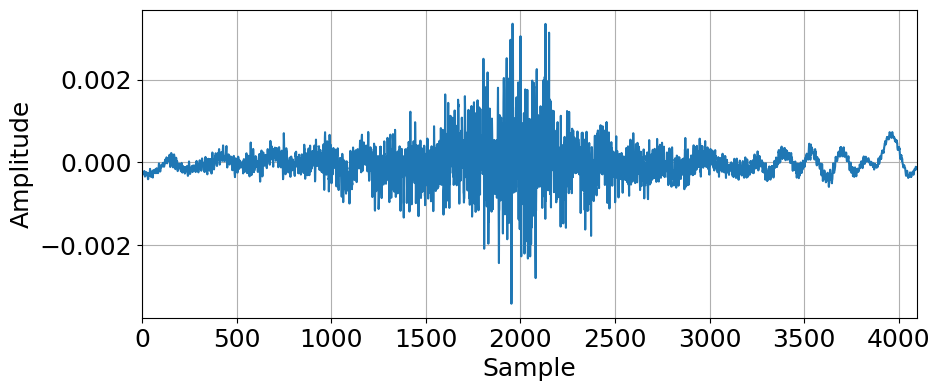

In [17]:
"""Pressure matching (PM) with zero phase"""
drvPM0 = sf.PressureMatching(G, reg[:,None,None], posSPK, des[None,:,None])

# Compute filter
smplShift = int(fftlen/2)
specPM0 = np.concatenate( (np.zeros((1,numSPK)), drvPM0, drvPM0[int(fftlen/2)-2::-1,:].conj()) )
sigPM0 = np.fft.ifft(specPM0, n=fftlen, axis=0).real
filterPM0 = np.concatenate( (sigPM0[fftlen-smplShift:fftlen,:], sigPM0[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterPM0[:,idxPlot])
ax.set_xlim(0,filterLen)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

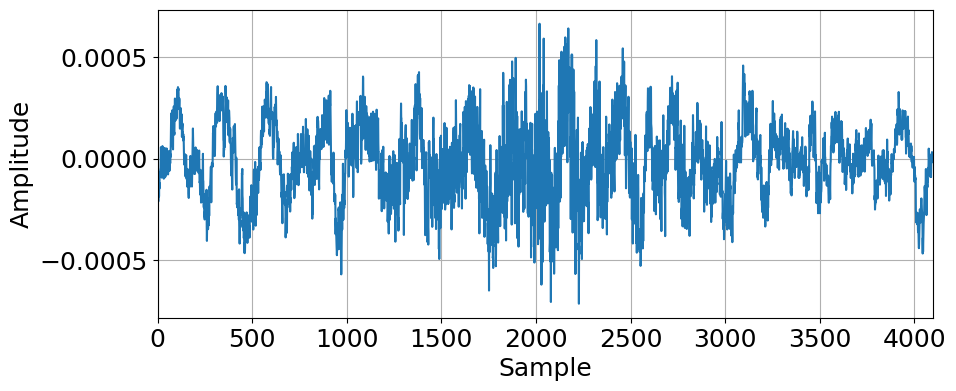

In [18]:
"""Acoustic contrast control (ACC)"""
drvACC = sf.AcoustContrastControl(GU, GL)

# Normalize amplitude 
synACC_U_tmp = np.squeeze( GU @ drvACC[:,:,None] )
ampACC = np.sqrt(synACC_U_tmp.shape[1]) / np.linalg.norm(synACC_U_tmp, axis=1) 
drvACC = ampACC[:,None] * drvACC

# Compute filter
smplShift = int(filterLen/2)
specACC = np.concatenate( (np.zeros((1,numSPK)), drvACC, drvACC[int(fftlen/2)-2::-1,:].conj()) )
sigACC = np.fft.ifft(specACC, n=fftlen, axis=0).real
filterACC = np.concatenate( (sigACC[fftlen-smplShift:fftlen,:], sigACC[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterACC[:,idxPlot])
ax.set_xlim(0,filterLen)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

i: 0, freq: 1.953125
i: 100, freq: 197.265625
i: 200, freq: 392.578125
i: 300, freq: 587.890625
i: 400, freq: 783.203125
i: 500, freq: 978.515625
i: 600, freq: 1173.828125
i: 700, freq: 1369.140625
i: 800, freq: 1564.453125
i: 900, freq: 1759.765625
i: 1000, freq: 1955.078125
i: 1100, freq: 2150.390625
i: 1200, freq: 2345.703125
i: 1300, freq: 2541.015625
i: 1400, freq: 2736.328125
i: 1500, freq: 2931.640625
i: 1600, freq: 3126.953125
i: 1700, freq: 3322.265625
i: 1800, freq: 3517.578125
i: 1900, freq: 3712.890625
i: 2000, freq: 3908.203125
i: 2100, freq: 4103.515625
i: 2200, freq: 4298.828125
i: 2300, freq: 4494.140625
i: 2400, freq: 4689.453125
i: 2500, freq: 4884.765625
i: 2600, freq: 5080.078125
i: 2700, freq: 5275.390625
i: 2800, freq: 5470.703125
i: 2900, freq: 5666.015625
i: 3000, freq: 5861.328125
i: 3100, freq: 6056.640625
i: 3200, freq: 6251.953125
i: 3300, freq: 6447.265625
i: 3400, freq: 6642.578125
i: 3500, freq: 6837.890625
i: 3600, freq: 7033.203125
i: 3700, freq: 7228.5

Text(0, 0.5, 'Amplitude')

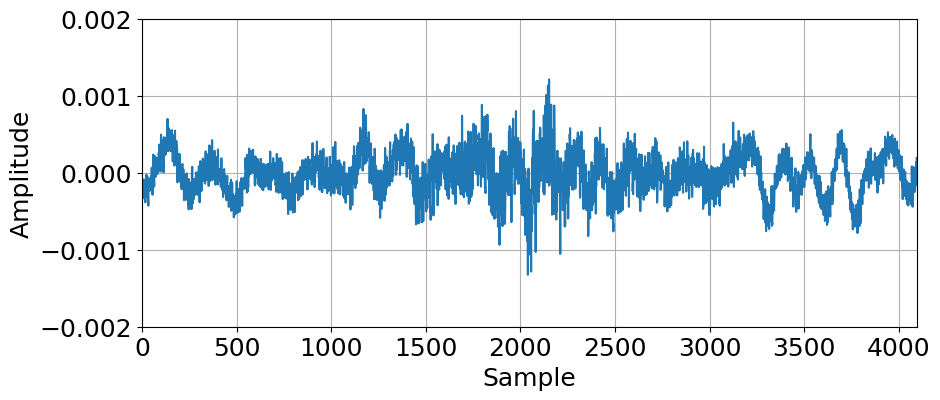

In [19]:
"""Amplitude matching with l2-norm penalty"""
# Parameters
dtol = 1e-3
max_iter = 1000

drvAM_ADMM_l2 = np.zeros([numFreq, numSPK]).astype("complex")
for i in range(numFreq):
    if i % 100 == 0:
        print("i: %d, freq: %f" % (i, freqVec[i]) )
    Gi = np.squeeze(G[i,:,:])
    regi = np.squeeze(reg[i])
    drv0 = np.squeeze(drvPM0[i,:])
    drvAM_ADMM_l2[i,:], _ = sf.ADMM(numSPK, des, Gi, regi, drv0, max_iter=max_iter, dtol=dtol)

# Compute filter
smplShift = int(fftlen/2)
specAM_ADMM_l2 = np.concatenate( (np.zeros((1,numSPK)), drvAM_ADMM_l2, drvAM_ADMM_l2[int(fftlen/2)-2::-1,:].conj()) )
sigAM_ADMM_l2 = np.fft.ifft(specAM_ADMM_l2, n=fftlen, axis=0).real
filterAM_ADMM_l2 = np.concatenate( (sigAM_ADMM_l2[fftlen-smplShift:fftlen,:], sigAM_ADMM_l2[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterAM_ADMM_l2[:,idxPlot])
ax.set_xlim(0,filterLen)
ax.set_ylim(-0.002,0.002)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

Balancer:  2048
Initializing......
itr: 0, ddiff: 0.987041
itr: 100, ddiff: 0.044984
itr: 200, ddiff: 0.036604
itr: 300, ddiff: 0.031601
itr: 400, ddiff: 0.024933
itr: 500, ddiff: 0.024537
itr: 600, ddiff: 0.024596
itr: 700, ddiff: 0.024316
itr: 800, ddiff: 0.024492
itr: 900, ddiff: 0.023658


Text(0, 0.5, 'Amplitude')

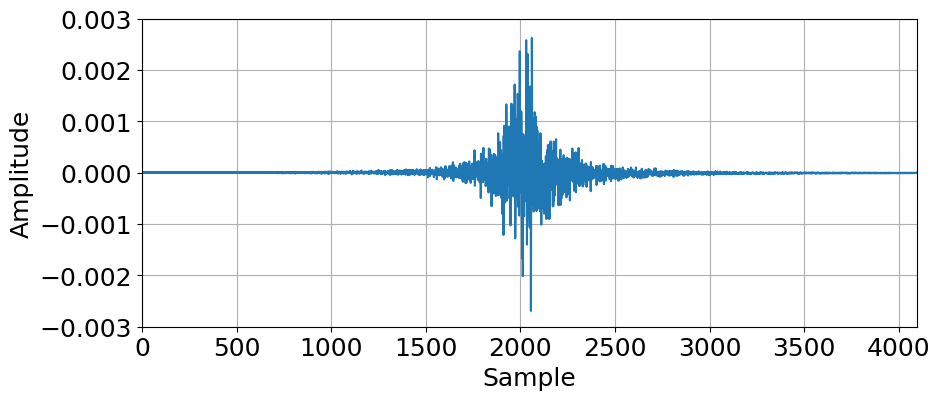

In [20]:
"""Amplitude matching with differential-norm penalty"""
# Parameters
dtol = 1e-3
max_iter = 1000
regDiff = 6250 

drvAM_ADMM_diff = sf.ADMMdiff(numSPK, numCP, numFreq, des, regDiff, drvPM0, G, max_iter=max_iter, dtol=dtol)

# Compute filter
smplShift = int(filterLen/2)
specAM_ADMM_diff = np.concatenate( (np.zeros((1,numSPK)), drvAM_ADMM_diff, drvAM_ADMM_diff[int(fftlen/2)-2::-1,:].conj()) )
sigAM_ADMM_diff = np.fft.ifft(specAM_ADMM_diff, n=fftlen, axis=0).real
filterAM_ADMM_diff = np.concatenate( (sigAM_ADMM_diff[fftlen-smplShift:fftlen,:], sigAM_ADMM_diff[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterAM_ADMM_diff[:,idxPlot])
ax.set_xlim(0,filterLen)
ax.set_ylim(-0.003,0.003)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

### Table IV and Figures 18 and 19: Evaluation

In [47]:
"""Synthesized sound field"""
fftlen = 16384
tfSim = np.fft.fft(irSim, n=fftlen, axis=0)[1:int(fftlen/2)+1,:,:]

# PM (zero phase)
fltspecPM0 = np.fft.fft(filterPM0, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecPM0_ = np.squeeze( tfSim @ fltspecPM0[:,:,None] )
synspecPM0_ = np.concatenate( (np.zeros((1,numSim)), synspecPM0_, synspecPM0_[int(fftlen/2)-2::-1,:].conj()) )
synPM0 = np.fft.ifft(synspecPM0_, n=fftlen, axis=0).real

# ACC
fltspecACC = np.fft.fft(filterACC, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecACC_ = np.squeeze( tfSim @ fltspecACC[:,:,None] )
synspecACC_ = np.concatenate( (np.zeros((1,numSim)), synspecACC_, synspecACC_[int(fftlen/2)-2::-1,:].conj()) )
synACC = np.fft.ifft(synspecACC_, n=fftlen, axis=0).real

# AM w/ l2-norm penalty
fltspecAM_ADMM_l2 = np.fft.fft(filterAM_ADMM_l2, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_l2_ = np.squeeze( tfSim @ fltspecAM_ADMM_l2[:,:,None] )
synspecAM_ADMM_l2_ = np.concatenate( (np.zeros((1,numSim)), synspecAM_ADMM_l2_, synspecAM_ADMM_l2_[int(fftlen/2)-2::-1,:].conj()) )
synAM_ADMM_l2 = np.fft.ifft(synspecAM_ADMM_l2_, n=fftlen, axis=0).real

# AM w/ differential-norm penalty
fltspecAM_ADMM_diff = np.fft.fft(filterAM_ADMM_diff, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_diff_ = np.squeeze( tfSim @ fltspecAM_ADMM_diff[:,:,None] )
synspecAM_ADMM_diff_ = np.concatenate( (np.zeros((1,numSim)), synspecAM_ADMM_diff_, synspecAM_ADMM_diff_[int(fftlen/2)-2::-1,:].conj()) )
synAM_ADMM_diff = np.fft.ifft(synspecAM_ADMM_diff_, n=fftlen, axis=0).real


[Average MSE] PM (zero phase): -10.4, ACC: -9.4, AM w/ l2 norm: -14.3, AM w/ Diff. norm: -20.8
[Average MSE in Omega_U] PM (zero phase): -9.6, ACC: -6.5, AM w/ l2 norm: -11.8, AM w/ Diff. norm: -19.6
[Average MSE in Omega_L] PM (zero phase): -11.3, ACC: -24.3, AM w/ l2 norm: -21.2, AM w/ Diff. norm: -22.4
[Average AC] PM (zero phase): 9.6, ACC: 23.8, AM w/ l2 norm: 20.4, AM w/ Diff. norm: 22.2


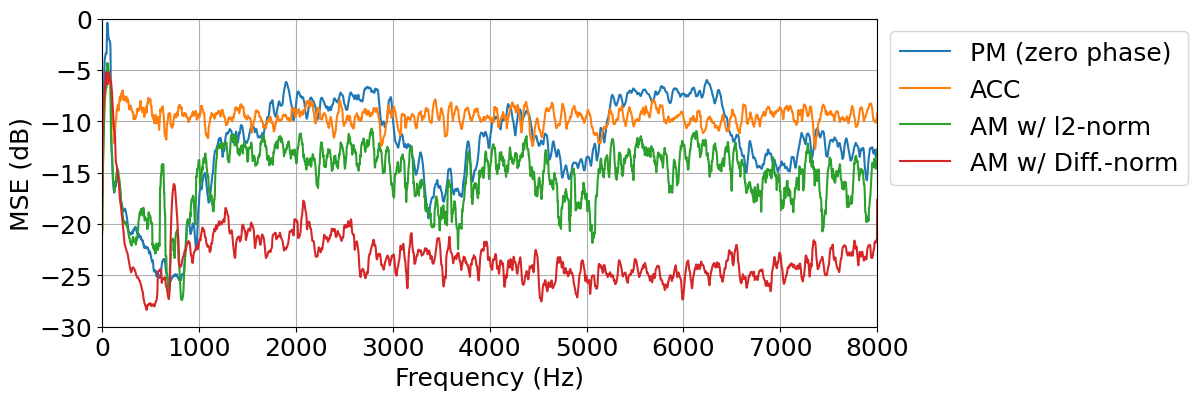

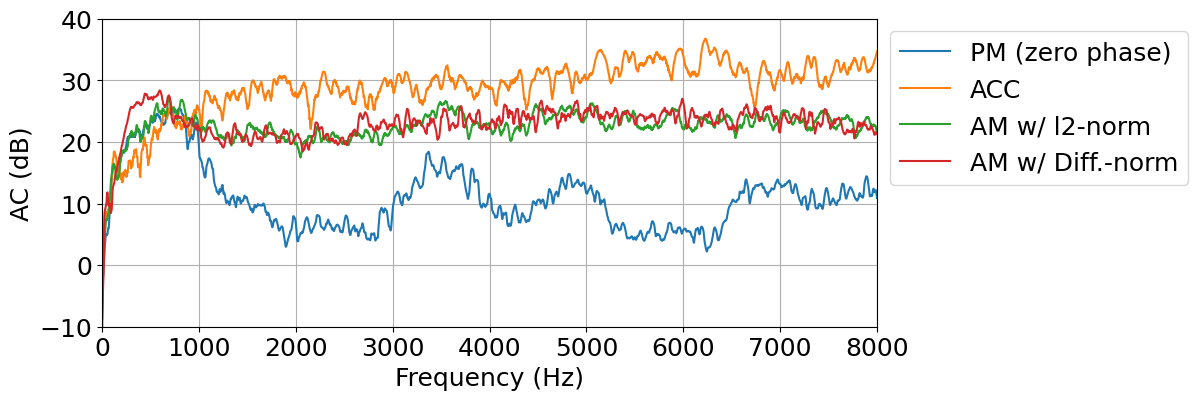

In [49]:
"""Evaluation"""
fftlen = 8192
numFreq = int(fftlen/2)
freqVec = np.linspace(0, 8000, numFreq+1)[1:]

synspecPM0 = np.fft.fft(synPM0, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecACC = np.fft.fft(synACC, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_l2 = np.fft.fft(synAM_ADMM_l2, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_diff = np.fft.fft(synAM_ADMM_diff, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]

# MSE
MSEma_PM0 = sf.MSEma(synspecPM0[:,idxCP], des)
MSEma_ACC = sf.MSEma(synspecACC[:,idxCP], des)
MSEma_AM_ADMM_l2 = sf.MSEma(synspecAM_ADMM_l2[:,idxCP], des)
MSEma_AM_ADMM_diff = sf.MSEma(synspecAM_ADMM_diff[:,idxCP], des)

MSEav_PM0 = sf.MSEav(synspecPM0[:,idxCP], des)
MSEav_ACC = sf.MSEav(synspecACC[:,idxCP], des)
MSEav_AM_ADMM_l2 = sf.MSEav(synspecAM_ADMM_l2[:,idxCP], des)
MSEav_AM_ADMM_diff = sf.MSEav(synspecAM_ADMM_diff[:,idxCP], des)
print("[Average MSE] PM (zero phase): %.1f, ACC: %.1f, AM w/ l2 norm: %.1f, AM w/ Diff. norm: %.1f" % (MSEav_PM0, MSEav_ACC, MSEav_AM_ADMM_l2, MSEav_AM_ADMM_diff) )

MSEav_PM0_U = sf.MSEav(synspecPM0[:,idxCP_U], des_U)
MSEav_ACC_U = sf.MSEav(synspecACC[:,idxCP_U], des_U)
MSEav_AM_ADMM_l2_U = sf.MSEav(synspecAM_ADMM_l2[:,idxCP_U], des_U)
MSEav_AM_ADMM_diff_U = sf.MSEav(synspecAM_ADMM_diff[:,idxCP_U], des_U)
print("[Average MSE in Omega_U] PM (zero phase): %.1f, ACC: %.1f, AM w/ l2 norm: %.1f, AM w/ Diff. norm: %.1f" % (MSEav_PM0_U, MSEav_ACC_U, MSEav_AM_ADMM_l2_U, MSEav_AM_ADMM_diff_U) )

MSEav_PM0_L = sf.MSEav(synspecPM0[:,idxCP_L], des_L)
MSEav_ACC_L = sf.MSEav(synspecACC[:,idxCP_L], des_L)
MSEav_AM_ADMM_l2_L = sf.MSEav(synspecAM_ADMM_l2[:,idxCP_L], des_L)
MSEav_AM_ADMM_diff_L = sf.MSEav(synspecAM_ADMM_diff[:,idxCP_L], des_L)
print("[Average MSE in Omega_L] PM (zero phase): %.1f, ACC: %.1f, AM w/ l2 norm: %.1f, AM w/ Diff. norm: %.1f" % (MSEav_PM0_L, MSEav_ACC_L, MSEav_AM_ADMM_l2_L, MSEav_AM_ADMM_diff_L) )

# AC
ACma_PM0 = sf.ACma(synspecPM0[:,idxCP_U], synspecPM0[:,idxCP_L])
ACma_ACC = sf.ACma(synspecACC[:,idxCP_U], synspecACC[:,idxCP_L])
ACma_AM_ADMM_l2 = sf.ACma(synspecAM_ADMM_l2[:,idxCP_U], synspecAM_ADMM_l2[:,idxCP_L])
ACma_AM_ADMM_diff = sf.ACma(synspecAM_ADMM_diff[:,idxCP_U], synspecAM_ADMM_diff[:,idxCP_L])

ACav_PM0 = sf.ACav(synspecPM0[:,idxCP_U], synspecPM0[:,idxCP_L])
ACav_ACC = sf.ACav(synspecACC[:,idxCP_U], synspecACC[:,idxCP_L])
ACav_AM_ADMM_l2 = sf.ACav(synspecAM_ADMM_l2[:,idxCP_U], synspecAM_ADMM_l2[:,idxCP_L])
ACav_AM_ADMM_diff = sf.ACav(synspecAM_ADMM_diff[:,idxCP_U], synspecAM_ADMM_diff[:,idxCP_L])
print("[Average AC] PM (zero phase): %.1f, ACC: %.1f, AM w/ l2 norm: %.1f, AM w/ Diff. norm: %.1f" % (ACav_PM0, ACav_ACC, ACav_AM_ADMM_l2, ACav_AM_ADMM_diff) )

# Plot MSE and AC
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, MSEma_PM0, label="PM (zero phase)")
ax.plot(freqVec, MSEma_ACC, label="ACC")
ax.plot(freqVec, MSEma_AM_ADMM_l2, label="AM w/ l2-norm")
ax.plot(freqVec, MSEma_AM_ADMM_diff, linestyle="-", label="AM w/ Diff.-norm")
ax.set_xlim(0,8000)
ax.set_ylim(-30, 0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('MSE (dB)')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, ACma_PM0, label="PM (zero phase)")
ax.plot(freqVec, ACma_ACC, label="ACC")
ax.plot(freqVec, ACma_AM_ADMM_l2, label="AM w/ l2-norm")
ax.plot(freqVec, ACma_AM_ADMM_diff, linestyle="-", label="AM w/ Diff.-norm")
ax.set_xlim(0,8000)
ax.set_ylim(-10, 40)
plt.xlabel('Frequency (Hz)')
plt.ylabel('AC (dB)')
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

Text(0, 0.5, 'y (m)')

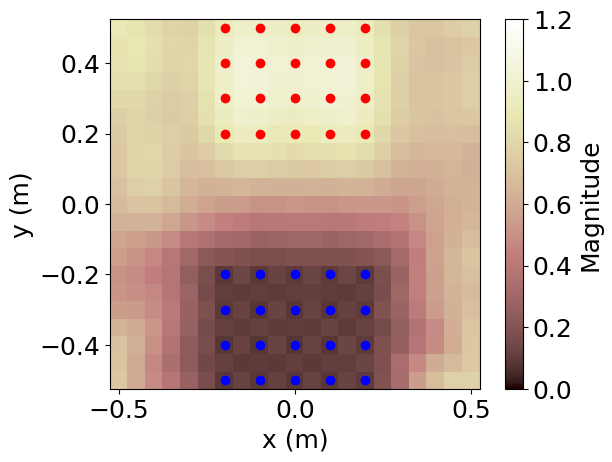

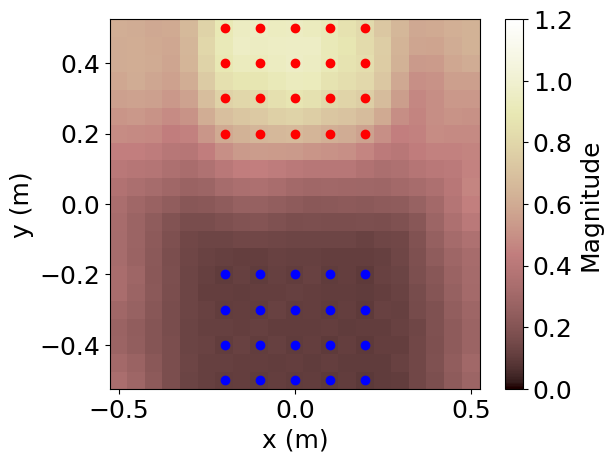

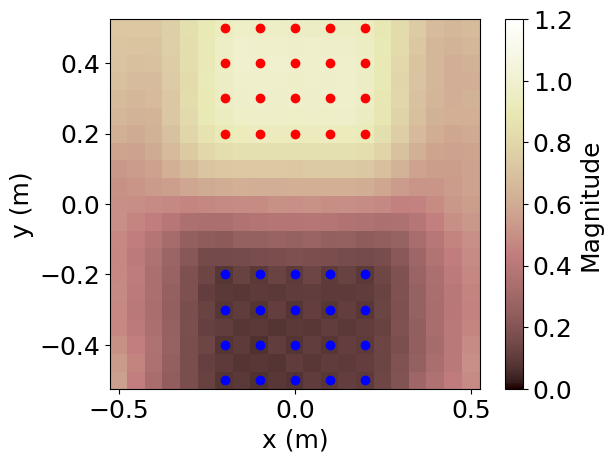

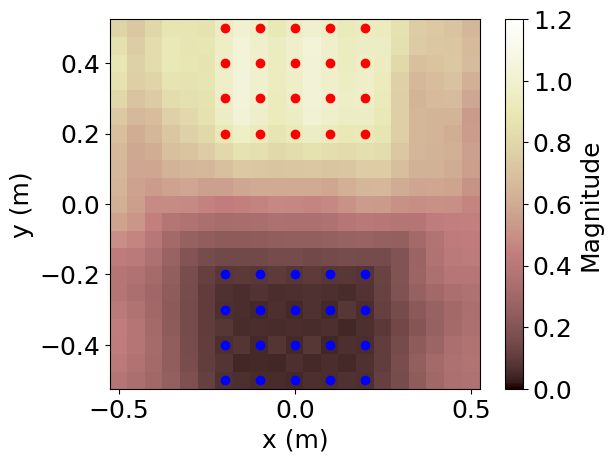

In [50]:
"""Amplitude distrubution"""
# Bandpass filter
minFreq = 100
maxFreq = 1000
h = signal.firwin(numtaps=256, cutoff=[minFreq, maxFreq], fs=samplerate, pass_zero=False)

# PM (zero phase)
synPM0_ = signal.filtfilt(h, 1, synPM0, axis=0) / np.sqrt(np.sum(np.abs(h)**2))
synampPM0 = np.sqrt( np.sum(np.abs(synPM0_)**2, axis=0) )
synampPM0_XY =  synampPM0[idxSimXY]

# ACC
synACC_ = signal.filtfilt(h, 1, synACC, axis=0) / np.sqrt(np.sum(np.abs(h)**2))
synampACC = np.sqrt( np.sum(np.abs(synACC_)**2, axis=0) )
synampACC_XY =  synampACC[idxSimXY]

# AM w/ l2-norm penalty
synAM_ADMM_l2_ = signal.filtfilt(h, 1, synAM_ADMM_l2, axis=0) / np.sqrt(np.sum(np.abs(h)**2))
synampAM_ADMM_l2 = np.sqrt( np.sum(np.abs(synAM_ADMM_l2_)**2, axis=0) )
synampAM_ADMM_l2_XY =  synampAM_ADMM_l2[idxSimXY]

# AM w/ differential-norm penalty
synAM_ADMM_diff_ = signal.filtfilt(h, 1, synAM_ADMM_diff, axis=0) / np.sqrt(np.sum(np.abs(h)**2))
synampAM_ADMM_diff = np.sqrt( np.sum(np.abs(synAM_ADMM_diff_)**2, axis=0) )
synampAM_ADMM_diff_XY =  synampAM_ADMM_diff[idxSimXY]

# Plot magnitude distribution
yy, xx = np.meshgrid(posSimY, posSimX)

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, synampPM0_XY, cmap='pink', vmin=0.0, vmax=1.2)
ax.scatter(posCP_U[:,0], posCP_U[:,1], marker='o', color='r')
ax.scatter(posCP_L[:,0], posCP_L[:,1], marker='o', color='b')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, synampACC_XY, cmap='pink', vmin=0.0, vmax=1.2)
ax.scatter(posCP_U[:,0], posCP_U[:,1], marker='o', color='r')
ax.scatter(posCP_L[:,0], posCP_L[:,1], marker='o', color='b')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, synampAM_ADMM_l2_XY, cmap='pink', vmin=0.0, vmax=1.2)
ax.scatter(posCP_U[:,0], posCP_U[:,1], marker='o', color='r')
ax.scatter(posCP_L[:,0], posCP_L[:,1], marker='o', color='b')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xx, yy, synampAM_ADMM_diff_XY, cmap='pink', vmin=0.0, vmax=1.2)
ax.scatter(posCP_U[:,0], posCP_U[:,1], marker='o', color='r')
ax.scatter(posCP_L[:,0], posCP_L[:,1], marker='o', color='b')
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')